## Overview

Ammunition manufactures provide a wealth of data for their cartridges. These data allow shooters to determine how 'flat' the trajectory of the rounds are and make adjustments for the drop and slow down of bullets at long range.

In this assignment we will use these data and see how well we can match observations to the output of a computational model. Scientists have been creating so-called ballistic models since the turn of the last century. Such models allow for:

* the anticipation of the long range characteristics of projectiles, 
* manufactures to answer 'what if' questions like what would be the the result of a lower drag bullet vs. a cartridge with more powder (a faster muzzle velocity), and 
* provide a high order interpolation between observations. 

In this class we will reproduce a pair of famous models for ballistics - the G1 and G7 models. Results of these models will be compared to the data from manufactures. 

Such an assignment is culturally appropriate for Montanans and has some interesting aspects for both code development and modeling. If hunting isn't your thing, there are many parallels to computing the point a meteorite or satellite impacts the Earth. Additionally there is a rich history of ideas the stem from considering the path or projectiles. The objectives of the lesson are to:

* gain an understanding of two dimensional motion, the ODEs that arise, and how they are solved.
* create modules for both data storage/retrieval and dynamical modeling.
* do a simple optimization.
* relate results in a tabular form.

### Two dimensional motion and solving ODEs

Until today, the ODEs we solved had only one dimension. For success with a projectile, we will need two dimensions. $x$ will be used to represent the range of the projectile - how far it travel over a flat Earth. The $y$ axis will represent the drop in the projectile as it moves down range. 

Let us suppose that we now have some vector drag force, $\mathbf{F_d}$. Now, the equations of motion would be

$$\mathbf{F} = m \mathbf{a} = m\mathbf{g} - \mathbf{F_d}$$

where we note that all quantities in **boldface** are vectors. That means that it's easier to write equations for $x$ and $y$ separately. Those are

$$ a_x = ~~- \mathbf{F_d}/m  \cdot \mathbf{\hat x}$$
$$ a_y = g - \mathbf{F_d}/m  \cdot \mathbf{\hat y}$$

Where $\mathbf{\hat x}$ is the unit vector in the $x$ direction and likewise for $\mathbf{\hat y}$. The mass has been divided through. These equations indicate that the drag force must be projected onto each of the two cardinal axes. We will return to this later. 

Lets conclude with a clear statement about what we require of the ODE solver. The $\mathbf{y_o}$ will be the initial state and consist of $(x^o,y^o,v^o_x,v^o_y)$; the 2 initial positions and 2 initial velocities. The function you write to pass to the ODE solver will return $(v_x^1,v_y^1,a_x^1,a_y^1)$; the 2 velocities and the 2 accelerations at time $t_1$, then given $t_1$, $t_2 will be returned, etc.

### In-class
Write the ODE function that does specifies the above drag equations in 2D. Assume that an object, instead of a parameter is passed to the function. This object includes a function `get_drag` that will accept a value $|\mathbf{v}|$ and return the magnitude of the drag force. Also assume the object contains $g$, the gravitational acceleration.


In [13]:
import numpy as np
from scipy.interpolate import interp1d
import requests
import urllib
def projectile(t,y,b):
    """
    t is not used
    y is the input state
    b is an object containing the ballistic model
    returns dy/dt
    """
    v = np.sqrt(y[2]**2+y[3]**2)

    F_d = b.get_drag(v)
    # print(F_d)
    # F_d = -.5
    return np.array([y[2],y[3], -F_d*y[2]/v, -g-F_d*y[3]/v])


In [14]:
def Euler(f,dt,t,y,args):
    """
    given y(t)
    :return: y(t+delta_t)
    """
    return y + f(t,y,*args)* dt

def EulerCromer(f,dt,t,y,args):
    y_end = Euler(f,dt,t,y,args)
    return y + f(t+dt,y_end,*args) * dt


def EulerRichardson(f,dt,t,y,args):
    y_mid = Euler(f,dt,t+dt/2,y,args)
    return y + f(t+dt/2,y_mid,*args) * dt


def solve_ode(f,tspan, y0, method = Euler, *args, **options):
    t_0 = tspan[0]
    t_f = tspan[1]
    d_t = options['first_step']
    t= [t_0]
    y = [y0]

    while t[-1]<= t_f:
        y.append(method(f,d_t,t[-1],y[-1],args))
        t.append(t[-1]+d_t)
    return np.array(t),np.array(y)



## The drag force
The drag force will be significant in determining the projectile's path. We begin with the following commonly used expression for drag force
$$\mathbf{F}_d= -{1 \over 2} \rho v^2 A C_d \mathbf{\hat v}$$

$C_d$ is the non-dimensional drag coefficient, $\rho$ is the density of the air the projectile travels through [Wikipedia:Density of Air](https://en.wikipedia.org/wiki/Density_of_air), $|v|$ is the magnitude of velocity, and $\mathbf{\hat v} = \frac{\mathbf{v}}{|\mathbf{v}|}$ the normalized velocity direction. Mass, if you are wondering, is drawn into $C_d$.

### The ballistic coefficient
Using the basic equation for drag force presents a problem. How will we determine $C_d$ for each of the many different bullets that are available? Further, we expect $C_d$ to be a function of the speed of the projectile, $C_d(v)$. This is too much measurement and too much fitting. Instead, consider the following strategy.

$S_d = \frac{m}{A}$ is the [Wikipedia:Sectional density](https://en.wikipedia.org/wiki/Sectional_density) of the projectile. It is the mass $m$ divided by the cross-sectional area $A$  of the bullet.

The form factor of a bullet is $f=\frac{C_d}{C^{\mathbf{G}}_{d}}$, where $C_d$ is the bullet's coefficient of drag, and $C^{\mathbf{G}}_{d}$ is the drag of a reference round. Here, we learn that $C_d$ isn't known, but that the calculation is done with respect to a round it is known for, called a *reference model*. That's the so-called G model, it is no more than a set of measurements for a single, 'reference' projectile. We will see that this ratio produces nice simplifications in the drag equation.

The **ballistic coefficient** is then the amount a bullet slows down in flight relative to a reference round. Based on the previous relations, this is expressed as 

$$b_c = \frac{S_d}{f}.$$ 

This is the number provided by the manufactures to tell shooters how well the bullet travels through the air. A value of 1.0 means the bullet has the same drag as the reference round. A value of greater than one would indicate the bullet experiences less drag than the reference round. A value less than one indicates the bullet experiences more drag than the reference round. Note that because of the dependence on $C^{\mathbf{G}}_{d}$ the ballistic coefficient is always with respect to some reference. Most manufactures report ballistic coefficients for G1 reference bullets only and use imperial units of measure. This has a tendency to make the value higher, which shooters like. The same value expressed for the (usually superior) G7 model is lower. So even if the model is better, the lower number turns off shooters that what to think bigger is better, so G1 remains, even if it was formulated in 1881 and involves a one pound bullet!

**Note the units of the ballistic coefficient.** They are pounds per inch squared in imperial units, and most manufactures report them in imperial units. To get to metric, you must convert to kilograms per meter squared.

In conclusion, to model the trajectory of a round, one uses published data on a reference round, and then computes how much the trajectory changes for a particular round. The difference between the reference round and the round in question is expressed as the inverse of the ballistic coefficient, $b_c$. A value of $b_c$ less than one indicates the round is impacted more by air resistance than the reference round. A value of $b_c$ greater than one indicates the projectile experiences less air resistance than the reference round.

### Final form of drag force

***Students do this in class***
To complete the analysis, multiply the right hand side of the original drag relation by one in the form of $\frac{b_c}{b_c}$. Write out the expression for $b_c$ based on the above discussion of sectional density and form factor. Replace the $b_c$ in the numerator with that. Achieve some cancelations and substitutions. Divide through by mass to give acceleration instead of force. Generalize $C_d$ to $C_d(m)$, where $m$ is the Mach number of the projectile, 

$$m = \frac{|\mathbf{v}|}{v_s}.$$

Here, $v_s$ is the speed of sound in air, see here for tables: [Wikipedia: Density of Air](https://en.wikipedia.org/wiki/Density_of_air). 

***Check answer***

As a result, any round's trajectory is expressed as a reference round's trajectory scaled by the ballistic coefficient of the particular round. This gives the following friction relation

$$ \mathbf{a_d} = -\frac{1}{2b_c} \rho C_d^{g}(m) |v|^2\mathbf{\hat v}.$$

Partitioning the force into ''x'' and ''y'' components based on the $\mathbf{\hat v}$, the equations of motion for the bullet take the following form

$$ a_x = ~~ - \frac{1}{2b_c}C_d^{g}(m) v^{2}\frac{v_x}{|\mathbf{v}|}$$

$$a_y =  -g - \frac{1}{2b_c}C_d^{g}(m) v^{2}\frac{v_y}{|\mathbf{v}|}$$

***In class***
Write a function that returns the magnitude of the drag function. Assume you have access to the other parts of the calculation, such as helper functions to convert units, a variable that sets the units, and whatever constants are needed.

In [15]:

import matplotlib.pyplot as plt

def data():
    #lapua  308 Scenar-L 155 grain
    
    return np.array([.460,.23])

weight = .010 #
size = .00783 # diamiter in m
area = np.pi * (size/2)**2

Altitude = 0
temp = 15 #15c
humitity = .75


def return_g_1():
    return np.array([[0.00, 0.2629],\
                [0.05, 0.2558],\
                [0.10, 0.2487],\
                [0.15, 0.2413],\
                [0.20, 0.2344],\
                [0.25, 0.2278],\
                [0.30, 0.2214],\
                [0.35, 0.2155],\
                [0.40, 0.2104],\
                [0.45, 0.2061],\
                [0.50, 0.2032],\
                [0.55, 0.2020],\
                [0.60, 0.2034],\
                [0.70, 0.2165],\
                [0.725, 0.2230],\
                [0.75, 0.2313],\
                [0.775, 0.2417],\
                [0.80, 0.2546],\
                [0.825, 0.2706],
                [0.85, 0.2901],
                [0.875, 0.3136],
                [0.90, 0.3415],
                [0.925, 0.3734],
                [0.95, 0.4084],
                [0.975, 0.4448],
                [1.0, 0.4805],
                [1.025, 0.5136],
                [1.05, 0.5427],
                [1.075, 0.5677],
                [1.10, 0.5883],
                [1.125, 0.6053],
                [1.15, 0.6191],
                [1.20, 0.6393],
                [1.25, 0.6518],
                [1.30, 0.6589],
                [1.35, 0.6621],
                [1.40, 0.6625],
                [1.45, 0.6607],
                [1.50, 0.6573],
                [1.55, 0.6528],
                [1.60, 0.6474],
                [1.65, 0.6413],
                [1.70, 0.6347],
                [1.75, 0.6280],
                [1.80, 0.6210],
                [1.85, 0.6141],
                [1.90, 0.6072],
                [1.95, 0.6003],
                [2.00, 0.5934],
                [2.05, 0.5867],
                [2.10, 0.5804],
                [2.15, 0.5743],
                [2.20, 0.5685],
                [2.25, 0.5630],
                [2.30, 0.5577],
                [2.35, 0.5527],
                [2.40, 0.5481],
                [2.45, 0.5438],
                [2.50, 0.5397],
                [2.60, 0.5325],
                [2.70, 0.5264],
                [2.80, 0.5211],
                [2.90, 0.5168],
                [3.00, 0.5133],
                [3.10, 0.5105],
                [3.20, 0.5084],
                [3.30, 0.5067],
                [3.40, 0.5054],
                [3.50, 0.5040],
                [3.60, 0.5030],
                [3.70, 0.5022],
                [3.80, 0.5016],
                [3.90, 0.5010],
                [4.00, 0.5006],
                [4.20, 0.4998],
                [4.40, 0.4995],
                [4.60, 0.4992],
                [4.80, 0.4990],
                [5.00, 0.4988]])

def return_g_7():
    return np.array([[0.00, 0.1198],\
                [0.05, 0.1197],\
                [0.10, 0.1196],\
                [0.15, 0.1194],\
                [0.20, 0.1193],\
                [0.25, 0.1194],\
                [0.30, 0.1194],\
                [0.35, 0.1194],\
                [0.40, 0.1193],\
                [0.45, 0.1193],\
                [0.50, 0.1194],\
                [0.55, 0.1193],\
                [0.60, 0.1194],\
                [0.65, 0.1197],\
                [0.70, 0.1202],\
                [0.725, 0.1207],\
                [0.75, 0.1215],\
                [0.775, 0.1226],\
                [0.80, 0.1242],\
                [0.825, 0.1266],\
                [0.85, 0.1306],\
                [0.875, 0.1368],\
                [0.90, 0.1464],\
                [0.925, 0.1660],\
                [0.95, 0.2054],\
                [0.975, 0.2993],\
                [1.0, 0.3803],\
                [1.025, 0.4015],\
                [1.05, 0.4043],\
                [1.075, 0.4034],\
                [1.10, 0.4014],\
                [1.125, 0.3987],\
                [1.15, 0.3955],\
                [1.20, 0.3884],\
                [1.25, 0.3810],\
                [1.30, 0.3732],\
                [1.35, 0.3657],\
                [1.40, 0.3580],\
                [1.50, 0.3440],\
                [1.55, 0.3376],\
                [1.60, 0.3315],\
                [1.65, 0.3260],\
                [1.70, 0.3209],\
                [1.75, 0.3160],\
                [1.80, 0.3117],\
                [1.85, 0.3078],\
                [1.90, 0.3042],\
                [1.95, 0.3010],\
                [2.00, 0.2980],\
                [2.05, 0.2951],\
                [2.10, 0.2922],\
                [2.15, 0.2892],\
                [2.20, 0.2864],\
                [2.25, 0.2835],\
                [2.30, 0.2807],\
                [2.35, 0.2779],\
                [2.40, 0.2752],\
                [2.45, 0.2725],\
                [2.50, 0.2697],\
                [2.55, 0.2670],\
                [2.60, 0.2643],\
                [2.65, 0.2615],\
                [2.70, 0.2588],\
                [2.75, 0.2561],\
                [2.80, 0.2533],\
                [2.85, 0.2506],\
                [2.90, 0.2479],\
                [2.95, 0.2451],\
                [3.00, 0.2424],\
                [3.10, 0.2368],\
                [3.20, 0.2313],\
                [3.30, 0.2258],\
                [3.40, 0.2205],\
                [3.50, 0.2154],\
                [3.60, 0.2106],\
                [3.70, 0.2060],\
                [3.80, 0.2017],\
                [3.90, 0.1975],\
                [4.00, 0.1935],\
                [4.20, 0.1861],\
                [4.40, 0.1793],\
                [4.60, 0.1730],\
                [4.80, 0.1672],\
                [5.00, 0.1618]])


class b_model:
    def __init__(self,mass,area):
        self.g = 9.8 # gravity
        self.ro =1.225 #kg/m # air density
        self.units = 'metric'
        self.m=mass #mass
        self.A=area # area
        self.form_factor="G1"
        self.S_d = mass/area # sectional Density

        self.set_b_c(data)

        self.T = 15 #temperature
        self.set_SoS()
        self.g_1_data = return_g_1()
        self.g_1_data[:,1] *= np.pi /4
        self.g_1_interp = interp1d(*self.g_1_data.T,kind='cubic')

        self.g_7_data = return_g_7()
        self.g_7_data[:,1] *= np.pi /4
        self.g_7_interp = interp1d(*self.g_7_data.T,kind='cubic')

    def set_SoS(self):

        self.speedosound = 331.1* np.sqrt(1+(self.T/273.15))
        if self.units == 'imperial':
            self.speedosound *=3.28084
    def set_Temp(self,T):
        self.T=T
        self.set_SoS()

    def get_g(self):
        return self.g

    def set_form(self,f):
        self.form_factor=f

    def set_units(self,type):
        self.units=type

    def get_drag(self,v):
        mach = v/self.speedosound
        cdg = self.get_CDG(mach)
        ad= .5/self.b_c * self.ro * cdg * v**2

        if self.units == 'imperial':
            ad *= 3.28084 # m/s^2 to ft/s^2
        return ad

    def get_CDG(self,mach):

        if self.form_factor == "G7":
            return self.g_7_interp(mach)
        if self.form_factor == "G1":
            return self.g_1_interp(mach)

    def set_b_c(self,f):
        temp = f()
        if self.form_factor == 'G1':
            self.b_c = temp[0]
        elif self.form_factor == "G7":
            self.b_c = temp[1]
        if self.units == 'metric':
            self.b_c *= 703.069 #  lb/in^2 to kg/m^2

    def get_elevation(self, lat, lon):


        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }
        url = r'https://nationalmap.gov/epqs/pqs.php?'
        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevation=(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
        self.set_ro(elevation)
        print(f"elevation {elevation}")


    def set_ro(self,alt):
        """

        :param alt: elevation in meters
        :param temp: tempiture in C

        :variable T: convered temp to K
        :variable pressure: converts elevation(m) to air pressure (Pa)

        :return:
        """


        self.ro  =  100 * ((44331.514 - alt) / 11880.516) ** (1 / 0.1902632) * 0.0101972/1000

        print(f"rho set to {self.ro}")



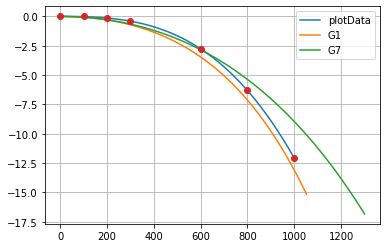

In [16]:
t_0 = 0.

y_0 = np.array([0.0,-.004,860,0.])
g= 9.8
bullet_data = np.array([-.004,0,-.115,-.414,-2.813,-6.265,-12.106])
bullet_dist = np.array([0,100,200,300,600,800,1000])
t_f = bullet_dist[-1]/y_0[2]*1.75
d_t = .001



app = b_model(weight,area)
app.set_form('G1')
t_1,y_1 = solve_ode(projectile,[t_0,t_f],y_0,EulerRichardson,*[app],first_step=d_t)

fit = np.polyfit(bullet_dist,bullet_data,3)
times = np.linspace(bullet_dist[0],bullet_dist[-1],len(y_1))
y_val = np.polyval(fit,times)

plt.plot(times,y_val,label='plotData')

plt.plot(y_1[:,0],y_1[:,1],label='G1')
app = b_model(weight,area)
app.set_form('G7')
t_7,y_7 = solve_ode(projectile,[t_0,t_f],y_0,EulerRichardson,*[app],first_step=d_t)
plt.plot(y_7[:,0],y_7[:,1],label='G7')
plt.legend()
plt.plot(bullet_dist,bullet_data,'o')
plt.grid(True)
plt.show()


In [17]:
zero_val= 100 # meters
theta=  theta_prev=0.001
theta_f=.5
error=.01


def zeroing(y,zero_value,form_factor):
    zero_val= zero_value # meters
    high = .01
    error=.001
    low=0.
    theta =0

    drop= np.inf
    while abs(drop)>error:
        theta = (high-low)/2+low
        y[3] = 860.*np.sin(theta)
        y[2] = 860.*np.cos(theta)
        app = b_model(weight,area)
        app.set_form(form_factor)
        t_e,y_e = solve_ode(projectile,[t_0,t_f],y_0,EulerRichardson,*[app],first_step=d_t)
        bullet_interp = interp1d(y_e[:,0],y_e[:,1],kind='cubic')
        drop = bullet_interp(zero_val)

        if drop>0:
            high= theta
            # print("Negative Drop")
        elif drop<0:
            # print("Positive Drop")
            low =  theta
    return  t_e,y_e,theta

### Difference in models
We will use both the G1 on G7 models, but what's the difference? It has to do with the projectile the data is taken on. The 'standard' projectiles of G1 and G7 are different. 

![G1 vs. G7 standard projectiles](Gmodels.png)

Above, you can see the G7 model is based on a more modern, low drag bullet that has a 'boat tail' end and longer nose. The G1 is an older type of round that's mostly historical in terms of shape. It also weighed a full pound! 

A rule of thumb here might be that the more the model looks like the bullet you use, the better you'll do.

### Tables of Data
The data is tabulated in the form of Mach number $m$ in the first column and $K_d$ in the second. $K_d$, what's that? Well it's an older way of relating the data. You'll need to apply the correction that 

$$ C_d = \frac{\pi}{4} K_d$$ to bring the values in the tables into agreement with the drag model we develop.

Data are from [here](https://www.jbmballistics.com/ballistics/downloads/downloads.shtml)

The relations are explored in a graph below.

#### G1 Model
`np.array([[0.00, 0.2629],\
                    [0.05, 0.2558],\
                    [0.10, 0.2487],\
                    [0.15, 0.2413],\
                    [0.20, 0.2344],\
                    [0.25, 0.2278],\
                    [0.30, 0.2214],\
                    [0.35, 0.2155],\
                    [0.40, 0.2104],\
                    [0.45, 0.2061],\
                    [0.50, 0.2032],\
                    [0.55, 0.2020],\
                    [0.60, 0.2034],\
                    [0.70, 0.2165],\
                    [0.725, 0.2230],\
                    [0.75, 0.2313],\
                    [0.775, 0.2417],\
                    [0.80, 0.2546],\
                    [0.825, 0.2706],\
                    [0.85, 0.2901],\
                    [0.875, 0.3136],\
                    [0.90, 0.3415],\
                    [0.925, 0.3734],\
                    [0.95, 0.4084],\
                    [0.975, 0.4448],\
                    [1.0, 0.4805],\
                    [1.025, 0.5136],\
                    [1.05, 0.5427],\
                    [1.075, 0.5677],\
                    [1.10, 0.5883],\
                    [1.125, 0.6053],\
                    [1.15, 0.6191],\
                    [1.20, 0.6393],\
                    [1.25, 0.6518],\
                    [1.30, 0.6589],\
                    [1.35, 0.6621],\
                    [1.40, 0.6625],\
                    [1.45, 0.6607],\
                    [1.50, 0.6573],\
                    [1.55, 0.6528],\
                    [1.60, 0.6474],\
                    [1.65, 0.6413],\
                    [1.70, 0.6347],\
                    [1.75, 0.6280],\
                    [1.80, 0.6210],\
                    [1.85, 0.6141],\
                    [1.90, 0.6072],\
                    [1.95, 0.6003],\
                    [2.00, 0.5934],\
                    [2.05, 0.5867],\
                    [2.10, 0.5804],\
                    [2.15, 0.5743],\
                    [2.20, 0.5685],\
                    [2.25, 0.5630],\
                    [2.30, 0.5577],\
                    [2.35, 0.5527],\
                    [2.40, 0.5481],\
                    [2.45, 0.5438],\
                    [2.50, 0.5397],\
                    [2.60, 0.5325],\
                    [2.70, 0.5264],\
                    [2.80, 0.5211],\
                    [2.90, 0.5168],\
                    [3.00, 0.5133],\
                    [3.10, 0.5105],\
                    [3.20, 0.5084],\
                    [3.30, 0.5067],\
                    [3.40, 0.5054],\
                    [3.50, 0.5040],\
                    [3.60, 0.5030],\
                    [3.70, 0.5022],\
                    [3.80, 0.5016],\
                    [3.90, 0.5010],\
                    [4.00, 0.5006],\
                    [4.20, 0.4998],\
                    [4.40, 0.4995],\
                    [4.60, 0.4992],\
                    [4.80, 0.4990],\
                    [5.00, 0.4988]])`
                    
#### G7 Model

`array([[0.00, 0.1198],\
                    [0.05, 0.1197],\
                    [0.10, 0.1196],\
                    [0.15, 0.1194],\
                    [0.20, 0.1193],\
                    [0.25, 0.1194],\
                    [0.30, 0.1194],\
                    [0.35, 0.1194],\
                    [0.40, 0.1193],\
                    [0.45, 0.1193],\
                    [0.50, 0.1194],\
                    [0.55, 0.1193],\
                    [0.60, 0.1194],\
                    [0.65, 0.1197],\
                    [0.70, 0.1202],\
                    [0.725, 0.1207],\
                    [0.75, 0.1215],\
                    [0.775, 0.1226],\
                    [0.80, 0.1242],\
                    [0.825, 0.1266],\
                    [0.85, 0.1306],\
                    [0.875, 0.1368],\
                    [0.90, 0.1464],\
                    [0.925, 0.1660],\
                    [0.95, 0.2054],\
                    [0.975, 0.2993],\
                    [1.0, 0.3803],\
                    [1.025, 0.4015],\
                    [1.05, 0.4043],\
                    [1.075, 0.4034],\
                    [1.10, 0.4014],\
                    [1.125, 0.3987],\
                    [1.15, 0.3955],\
                    [1.20, 0.3884],\
                    [1.25, 0.3810],\
                    [1.30, 0.3732],\
                    [1.35, 0.3657],\
                    [1.40, 0.3580],\
                    [1.50, 0.3440],\
                    [1.55, 0.3376],\
                    [1.60, 0.3315],\
                    [1.65, 0.3260],\
                    [1.70, 0.3209],\
                    [1.75, 0.3160],\
                    [1.80, 0.3117],\
                    [1.85, 0.3078],\
                    [1.90, 0.3042],\
                    [1.95, 0.3010],\
                    [2.00, 0.2980],\
                    [2.05, 0.2951],\
                    [2.10, 0.2922],\
                    [2.15, 0.2892],\
                    [2.20, 0.2864],\
                    [2.25, 0.2835],\
                    [2.30, 0.2807],\
                    [2.35, 0.2779],\
                    [2.40, 0.2752],\
                    [2.45, 0.2725],\
                    [2.50, 0.2697],\
                    [2.55, 0.2670],\
                    [2.60, 0.2643],\
                    [2.65, 0.2615],\
                    [2.70, 0.2588],\
                    [2.75, 0.2561],\
                    [2.80, 0.2533],\
                    [2.85, 0.2506],\
                    [2.90, 0.2479],\
                    [2.95, 0.2451],\
                    [3.00, 0.2424],\
                    [3.10, 0.2368],\
                    [3.20, 0.2313],\
                    [3.30, 0.2258],\
                    [3.40, 0.2205],\
                    [3.50, 0.2154],\
                    [3.60, 0.2106],\
                    [3.70, 0.2060],\
                    [3.80, 0.2017],\
                    [3.90, 0.1975],\
                    [4.00, 0.1935],\
                    [4.20, 0.1861],\
                    [4.40, 0.1793],\
                    [4.60, 0.1730],\
                    [4.80, 0.1672],\
                    [5.00, 0.1618]])`

In [18]:
# In-class - create a ballistics model that stores and retrieves the data in the above arrays in such a way as to 
# allow the plots below to be constructed.



### Assignment
* Develop a class to encapsulate the data for the G1 and G7 models. These data are expressed in the tables that appear below. The class should also have a function to return the drag,important constants, facilities to convert from imperial to metric calculations and interpolation for the tabular data.
* Select a cartridge that includes long range (1200 meters or more) trajectory data and ballistic coefficients for both models. That's not always easy, manufacturers often have incomplete data on ballistic coefficients (G1 but not G7). Some manufacturers you might check can be found [here](https://en.wikipedia.org/wiki/Category:Ammunition_manufacturers) . A good fallback is the Finnish company, [Lapua](https://www.lapua.com/ammunition/tactical-cartridges/), which is excellent where data are concerned. But, it's always more interesting when there are a variety of rounds selected. Do not use handgun rounds. They don't go far enough to be constrained by data.
* You will need to devise a method for making certain that the projectile is zeroed at the appropriate point on the trajectory. To do this, the projectile must be fired at an angle with respect to horizontal making initial velocities $v^0_x = v_m cos\theta$ and $v^0_y = v_m sin\theta$, where $v_m$ is the muzzle velocity of the cartridge you select.
* Take into account the scope is above the barrel. As such, the initial position in -5 cm below the zero.
* Compare the trajectory of the cartridge you select to the trajectory produced by each of the models. Do so with both graphs and well printed tables. I used "`prettytable`".
* Provide commentary on which ballistic model appears to be best suited to your cartridge. You will also need to develop a quantitative metric for assessing the ''goodness of fit'' of the model to the data. Note that the ballistic coefficient is with respect to each model (a different reference bullet is used). Don't forget that the ballistic coefficient has dimensions.
* Improve upon the model in some way. This could be improvising a $C_d$ curve that is more suitable for your round, by improving the $\rho$ model, by implementing another G type model (see below, several are available), or something else you might dream up. I found that reading the [Wikipedia: Ballistic Coefficient](https://en.wikipedia.org/wiki/Ballistic_coefficient) page stirred my magination. Show the improvement for your round, and then, without further optimization, try your improved model on a new cartidge. Did it do better for that cartidge too?



### Changes Made to balistic function 
- Added ability to change tempiture  this changes Speed of sound
- Added ability to manually change elevation this effects the air pressure
- Added ability to enter latitude and longitude to find elevation for location to then change pressure
    - The API I use seems to have some preformance issues and may time out from time to time.
- I wanted to be able to take in to account humidity but the equations i found for it were a little beyond my understanding

In [ ]:
z_value =100
t_1,y_1,theta_1= zeroing(y_0,z_value,'G1')

t_7,y_7,theta_7= zeroing(y_0,z_value,'G7')


In [ ]:

plt.plot(times,y_val,label='plotData')
plt.title(f"Sighted in at {z_value}")
plt.plot(y_1[:,0],y_1[:,1],label=f'G1 theta {theta_1}')
plt.plot(y_7[:,0],y_7[:,1],label=f'G7 theta {theta_7}')
plt.legend()
plt.plot(bullet_dist,bullet_data,'o')
plt.grid(True)
plt.show()


In [ ]:
from prettytable import PrettyTable
norm_g7 = (np.linalg.norm(y_7[:,1]-y_val,2))
norm_g1 = (np.linalg.norm(y_1[:,1]-y_val,2))

print(f"the g1 formfactor has a l2 norm of {norm_g7}")
print(f"the g7 formfactor has a l2 norm of {norm_g1}")


drop = interp1d(y_1[:,0],y_1[:,1],kind='cubic')
drop_t = np.array(["Drop (cm)",drop(100)*100,drop(200)*100,drop(300)*100,drop(600)*100,drop(800)*100,drop(1000)*100])
drop_delta =['Drop Error(cm)',0.,0.,0.,0.,0.,0.]
for i in range(6):
    drop_delta[i+1] = float(drop_t[i+1])-(float(bullet_data[i+1]))*100

speed = interp1d(y_1[:,0],y_1[:,2],kind='cubic')
speed_t = np.array(["Speed (m/s)",speed(100),speed(200),speed(300),speed(600),speed(800),speed(1000)])

bullet_speed = np.array([860.,794.,730,669,503,408,331])
speed_delta =['Speed Error (m/s)',0.,0.,0.,0.,0.,0.]
for i in range(6):
    speed_delta[i+1] = (float(speed_t[i+1])-float(bullet_speed[i+1]))

tab = PrettyTable()
col_names = ["Distance (m)","100","200","300","600" ,  " 800","1000"]
tab.field_names=col_names
tab.add_row(drop_t)
tab.add_row(drop_delta)
tab.add_row(speed_t)
tab.add_row(speed_delta)
print(tab)



In [ ]:
theta = .000741875
y_0[3] = 860.*np.sin(theta)
y_0[2] = 860.*np.cos(theta)
app = b_model(weight,area)
app.set_form('G1')
app.set_Temp(22)
# app.get_elevation(46.844809563252106, -114.0464491898589)
app.set_ro(800)
t_e,y_e = solve_ode(projectile,[t_0,t_f],y_0,EulerRichardson,*[app],first_step=d_t)


plt.plot(times,y_val,label='plotData')
plt.title(f"Sighted in at {z_value}")
plt.plot(y_1[:,0],y_1[:,1],label=f'G1 theta {theta_1}')
plt.plot(y_e[:,0],y_e[:,1],label=f'Temp ajustment')
plt.legend()
plt.plot(bullet_dist,bullet_data,'o')
plt.grid(True)
plt.show()
print(np.linalg.norm(y_e[:,1]-y_val))


## Interesting the new bullet is more accurate to the G7

In [ ]:
## New bullet


def data():
    #lapua  338

    return np.array([.625,.310])

weight = .0162 #
size = .00860 # diamiter in m
area = np.pi * (size/2)**2

t_0 = 0.

y_0 = np.array([0.0,-.004,905,0.])
g= 9.8
bullet_data = np.array([-.004,0,-.093,-.336,-2.164,-4.570,-8.274])
bullet_dist = np.array([0,100,200,300,600,800,1000])
t_f = bullet_dist[-1]/y_0[2]*1.75
d_t = .001


z_value =100
t_1,y_1,theta_1= zeroing(y_0,z_value,'G1')

t_7,y_7,theta_7= zeroing(y_0,z_value,'G7')

In [ ]:
fit = np.polyfit(bullet_dist,bullet_data,3)
times = np.linspace(bullet_dist[0],bullet_dist[-1],len(y_1))
y_val = np.polyval(fit,times)


plt.plot(times,y_val,label='plotData')
plt.title(f"Sighted in at {z_value}")
plt.plot(y_1[:,0],y_1[:,1],label=f'G1 theta {theta_1}')
plt.plot(y_7[:,0],y_7[:,1],label=f'G7 theta {theta_7}')
plt.legend()
plt.plot(bullet_dist,bullet_data,'o')
plt.grid(True)
plt.show()